In [30]:

import numpy as np
import math

L, d_k, d_v = 4, 8, 8
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)
print(q)

[[-0.90184977  0.15411072  0.3706254  -0.19573535 -0.20905336 -0.04206784
   0.05644867 -1.68299375]
 [-0.41769654 -1.19041593  0.24163268  0.72984339  0.42819747 -0.10946848
  -0.26156017 -0.60022088]
 [-0.40550481  0.36050594  0.09617871 -0.36587733  0.2692972   0.6496429
   0.53975705 -1.35073673]
 [-1.1460233  -2.03122525  0.42927282  1.40763456  1.36883224  1.49562401
  -0.18552601 -1.92750317]]


In [31]:
np.matmul(q, k.T)

array([[-0.19960643, -1.19657572, -2.42658099,  0.96070104],
       [ 0.65068232, -0.86005545, -2.41887907, -0.42951497],
       [-0.11240723, -0.76060531, -0.84404746,  1.29965861],
       [-0.62761341, -3.02248007, -5.15491062,  0.54064569]])

In [3]:
q.var(), k.var(), np.matmul(q, k.T).var()

(1.126221119112162, 0.9905244163595975, 8.356847786707736)

In [32]:
""" Dividing by the square root of the dimension of the key vectors dk in the self-attention mechanism is a technique
 to prevent the dot product from growing too large in magnitude"""
scaled = np.matmul(q, k.T) / math.sqrt(d_k)
q.var(), k.var(), scaled.var()

(0.7687976543737907, 1.0225989493190337, 0.3245577325617038)

In [14]:
scaled

array([[-0.29120271,  0.19411435,  1.74576012, -1.08729967],
       [ 0.62970807,  1.07110441,  0.21920558, -0.68585846],
       [-0.79647138, -1.16257883, -0.66547283, -1.07039639],
       [ 0.18926566,  0.04490585, -1.49451507,  2.12600157]])

In [33]:

mask = np.tril(np.ones( (L, L) ))
mask

array([[1., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

In [34]:
mask[mask == 0] = -np.infty
mask[mask == 1] = 0

In [35]:
sc=scaled + mask
sc

array([[-0.07057153,        -inf,        -inf,        -inf],
       [ 0.23005094, -0.30407552,        -inf,        -inf],
       [-0.03974196, -0.26891458, -0.29841584,        -inf],
       [-0.22189485, -1.06860808, -1.82253613,  0.19114712]])

In [36]:
np.exp(sc)

array([[0.93186108, 0.        , 0.        , 0.        ],
       [1.25866412, 0.73780515, 0.        , 0.        ],
       [0.9610374 , 0.76420853, 0.74199272, 0.        ],
       [0.80099959, 0.34348629, 0.16161535, 1.21063755]])

In [37]:
np.sum(np.exp(sc), axis=-1)
""" hen np.sum(x, axis=-1) will sum across the last axis (columns in a 2D array),
resulting in a 1D array where each element is the sum of each row of the original array"""

' hen np.sum(x, axis=-1) will sum across the last axis (columns in a 2D array), \nresulting in a 1D array where each element is the sum of each row of the original array'

In [38]:
def softmax(x):
  return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

attention=softmax(sc)
print(attention)

[[1.         0.         0.         0.        ]
 [0.63044503 0.36955497 0.         0.        ]
 [0.38951943 0.30974244 0.30073812 0.        ]
 [0.31826886 0.13648071 0.06421618 0.48103425]]


MULTIHEAD ATTENTION

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [41]:

sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )
print(x.shape)

torch.Size([1, 4, 512])


In [42]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

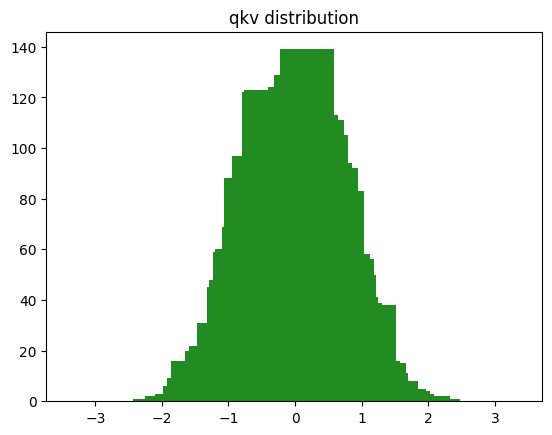

In [43]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [44]:
num_heads = 8
"""Since it is multihead q,k,v dim will be further divided into numod heads so 512/8=64"""
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

Self-attention in a transformer allows each word in a sentence to influence the representation of every other word. For instance, in the sentence "The animal didn't cross the street because it was too tired," self-attention allows the model to associate "it" with "animal" by weighting that connection more heavily. This mechanism dynamically adjusts based on context, enabling the model to understand relationships and dependencies in the data, regardless of their position in the input sequence. This is crucial for tasks requiring an understanding of context and semantics.

In [46]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [47]:

qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [48]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape


(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [67]:
print(q.shape)
k.transpose(-2, -1).shape

torch.Size([1, 8, 4, 64])


torch.Size([1, 8, 64, 4])

In [53]:
scaled.shape
"""calculate the output dimensions of a matrix multiplication (matmul),
 follow this rule: If you multiply two matrices of dimensions (a, b) and (b, c), the resulting matrix will have dimensions (a, c)."""

(4, 4)

In [69]:
d_k = q.size()[-1]
print(d_k)
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape


64


torch.Size([1, 8, 4, 4])

In [60]:
mask = torch.full(scaled.size() , float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][0]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [62]:
(scaled + mask).shape

torch.Size([1, 8, 4, 4])

In [63]:
scaled += mask

attention = F.softmax(scaled, dim=-1)


In [64]:
attention.shape

torch.Size([1, 8, 4, 4])

In [66]:
v.shape

torch.Size([1, 8, 4, 64])

In [68]:

values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [70]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out



In [71]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


Positional encoding

In [74]:
import torch
import torch.nn as nn

max_sequence_length = 10
d_model = 6

In [75]:

even_i = torch.arange(0, d_model, 2).float()
print(even_i)
even_denominator = torch.pow(10000, even_i/d_model)
print(even_denominator)


tensor([0., 2., 4.])
tensor([  1.0000,  21.5443, 464.1590])


In [77]:
odd_i = torch.arange(1, d_model, 2).float()
even_denominator = torch.pow(10000, (odd_i - 1)/d_model)
even_denominator

tensor([  1.0000,  21.5443, 464.1590])

In [78]:
denominator = even_denominator
position = torch.arange(max_sequence_length, dtype=torch.float).reshape(max_sequence_length, 1)
position

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])

In [79]:
even_PE = torch.sin(position / denominator)
odd_PE = torch.cos(position / denominator)
print(even_PE)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.8415,  0.0464,  0.0022],
        [ 0.9093,  0.0927,  0.0043],
        [ 0.1411,  0.1388,  0.0065],
        [-0.7568,  0.1846,  0.0086],
        [-0.9589,  0.2300,  0.0108],
        [-0.2794,  0.2749,  0.0129],
        [ 0.6570,  0.3192,  0.0151],
        [ 0.9894,  0.3629,  0.0172],
        [ 0.4121,  0.4057,  0.0194]])


In [80]:
odd_PE

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 0.5403,  0.9989,  1.0000],
        [-0.4161,  0.9957,  1.0000],
        [-0.9900,  0.9903,  1.0000],
        [-0.6536,  0.9828,  1.0000],
        [ 0.2837,  0.9732,  0.9999],
        [ 0.9602,  0.9615,  0.9999],
        [ 0.7539,  0.9477,  0.9999],
        [-0.1455,  0.9318,  0.9999],
        [-0.9111,  0.9140,  0.9998]])

In [103]:
stacked = torch.stack([even_PE, odd_PE], dim=2)
stacked.shape

torch.Size([10, 3, 2])

In [104]:
stacked

tensor([[[ 0.0000,  1.0000],
         [ 0.0000,  1.0000],
         [ 0.0000,  1.0000]],

        [[ 0.8415,  0.5403],
         [ 0.0464,  0.9989],
         [ 0.0022,  1.0000]],

        [[ 0.9093, -0.4161],
         [ 0.0927,  0.9957],
         [ 0.0043,  1.0000]],

        [[ 0.1411, -0.9900],
         [ 0.1388,  0.9903],
         [ 0.0065,  1.0000]],

        [[-0.7568, -0.6536],
         [ 0.1846,  0.9828],
         [ 0.0086,  1.0000]],

        [[-0.9589,  0.2837],
         [ 0.2300,  0.9732],
         [ 0.0108,  0.9999]],

        [[-0.2794,  0.9602],
         [ 0.2749,  0.9615],
         [ 0.0129,  0.9999]],

        [[ 0.6570,  0.7539],
         [ 0.3192,  0.9477],
         [ 0.0151,  0.9999]],

        [[ 0.9894, -0.1455],
         [ 0.3629,  0.9318],
         [ 0.0172,  0.9999]],

        [[ 0.4121, -0.9111],
         [ 0.4057,  0.9140],
         [ 0.0194,  0.9998]]])

torch.flatten(stacked, start_dim=1, end_dim=2) flattens the tensor stacked starting from start_dim=1 to end_dim=2. This means it collapses the second and third dimensions of the tensor into a single dimension, effectively transforming a tensor of shape (n, m, 2) into shape (n, m*2)

In [109]:
PE = torch.flatten(stacked, start_dim=1, end_dim=2)
PE

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000],
        [-0.7568, -0.6536,  0.1846,  0.9828,  0.0086,  1.0000],
        [-0.9589,  0.2837,  0.2300,  0.9732,  0.0108,  0.9999],
        [-0.2794,  0.9602,  0.2749,  0.9615,  0.0129,  0.9999],
        [ 0.6570,  0.7539,  0.3192,  0.9477,  0.0151,  0.9999],
        [ 0.9894, -0.1455,  0.3629,  0.9318,  0.0172,  0.9999],
        [ 0.4121, -0.9111,  0.4057,  0.9140,  0.0194,  0.9998]])

Layer Normalization

In [1]:

import torch
from torch import nn

In [15]:
inputs = torch.Tensor([[[0.2, 0.1, 0.3], [0.5, 0.1, 0.1]]])
B, S, E = inputs.size()
inputs = inputs.reshape(S, B, E)
inputs.size()


torch.Size([2, 1, 3])

In [16]:

parameter_shape = inputs.size()[-2:]
gamma = nn.Parameter(torch.ones(parameter_shape))
beta =  nn.Parameter(torch.zeros(parameter_shape))

In [17]:

gamma.size(), beta.size()

(torch.Size([1, 3]), torch.Size([1, 3]))

In [18]:
print(len(parameter_shape))
dims = [-(i + 1) for i in range(len(parameter_shape))]
print(dims) #need to apply layer normalization on last 2 layers

2
[-1, -2]


In [24]:
print(inputs.shape)
mean = inputs.mean(dim=dims, keepdim=True)
mean.size()

torch.Size([2, 1, 3])


torch.Size([2, 1, 1])

In [13]:
inputs_test = torch.Tensor([[[[0.2, 0.1, 0.3],[0.2, 0.5, 0.3]], [[0.5, 0.1, 0.1],[0.5, 0.9, 0.1]]]])
print(inputs_test.shape)
mean = inputs_test.mean(dim=dims, keepdim=True)
print(mean)
mean.size()

torch.Size([1, 2, 2, 3])
tensor([[[[0.2667]],

         [[0.3667]]]])


torch.Size([1, 2, 1, 1])

In [26]:
print("Mean",inputs - mean)
var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
print("var",var,var.shape)
epsilon = 1e-5
std = (var + epsilon).sqrt()
std

Mean tensor([[[ 0.0000, -0.1000,  0.1000]],

        [[ 0.2667, -0.1333, -0.1333]]])
var tensor([[[0.0067]],

        [[0.0356]]]) torch.Size([2, 1, 1])


tensor([[[0.0817]],

        [[0.1886]]])

In [27]:
y = (inputs - mean) / std
print(y,y.shape)


tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]]) torch.Size([2, 1, 3])


In [23]:
print(y.shape,gamma.shape)
out = gamma * y + beta
print(out)

torch.Size([2, 1, 3]) torch.Size([1, 3])
tensor([[[ 0.0000, -1.2238,  1.2238]],

        [[ 1.4140, -0.7070, -0.7070]]], grad_fn=<AddBackward0>)


The output tensor you're seeing with a grad_fn component indicates that this tensor is part of PyTorch's autograd system, which automatically tracks operations on tensors for which gradients may need to be calculated. This is typical for tensors that result from operations on tensors with requires_grad=True,
Since gamma and beta is consider as trainalbe parameter automatically

In [39]:
import torch
from torch import nn

class LayerNormalization():
    def __init__(self, parameters_shape, eps=1e-5):
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))
        print(self.gamma.shape)

    def forward(self, input):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        print("Dims",dims)
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean \n ({mean.size()}): \n {mean}")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation \n ({std.size()}): \n {std}")
        y = (inputs - mean) / std
        print(f"y \n ({y.size()}) = \n {y}")
        out = self.gamma * y  + self.beta
        print(f"out \n ({out.size()}) = \n {out}")
        return out

In [36]:
batch_size = 3
sentence_length = 5
embedding_dim = 8
inputs = torch.randn(sentence_length, batch_size, embedding_dim)

print(f"input \n ({inputs.size()}) = \n {inputs}")

input 
 (torch.Size([5, 3, 8])) = 
 tensor([[[-0.1772, -0.8778, -0.2209, -0.2623,  0.2507, -0.2624,  0.1441,
          -0.8016],
         [-1.1089,  0.0484, -0.7263, -0.5982, -1.4576,  0.9606,  0.3574,
           0.1240],
         [-1.4296,  1.9855, -2.1145, -1.0625, -1.1589, -1.2160, -1.7107,
           1.6340]],

        [[-0.3196,  0.3523, -0.3200,  0.1945, -0.3626,  0.7313, -1.7217,
          -1.2250],
         [-0.4733,  0.0865,  0.0667,  1.9651,  0.1626,  0.8184, -1.1543,
           1.2310],
         [-0.6515,  0.8125, -1.1692, -0.0534, -1.5445,  0.2102, -2.1683,
           0.2088]],

        [[-0.6443,  1.3153, -0.5172,  2.0981,  1.4767, -1.2782,  1.6193,
           0.4117],
         [ 0.4125,  0.0935, -0.6681, -0.0903,  0.0721,  1.4806, -0.6909,
           0.8981],
         [-0.1701, -0.7780, -1.7566, -0.1337, -0.2035,  1.1230, -1.5906,
          -2.0821]],

        [[ 1.1599, -0.0198,  0.1793,  0.0742,  0.5565, -0.5228, -0.2151,
          -1.3535],
         [ 1.9157,  0.6849, 

In [40]:
print(inputs.size()[-1])
layer_norm = LayerNormalization(inputs.size()[-1:])
print(layer_norm)

8
torch.Size([8])


In [41]:
out = layer_norm.forward(inputs)
print(out.shape)

Dims [-1]
Mean 
 (torch.Size([5, 3, 1])): 
 tensor([[[-0.2759],
         [-0.3001],
         [-0.6341]],

        [[-0.3339],
         [ 0.3379],
         [-0.5444]],

        [[ 0.5602],
         [ 0.1884],
         [-0.6990]],

        [[-0.0177],
         [ 0.3897],
         [ 0.3659]],

        [[-0.0740],
         [ 0.4636],
         [-1.0051]]])
Standard Deviation 
 (torch.Size([5, 3, 1])): 
 tensor([[[0.3718],
         [0.7573],
         [1.4486]],

        [[0.7588],
         [0.9171],
         [0.9525]],

        [[1.1678],
         [0.6920],
         [0.9998]],

        [[0.6930],
         [0.8998],
         [0.8577]],

        [[0.8811],
         [0.6478],
         [0.7612]]])
y 
 (torch.Size([5, 3, 8])) = 
 tensor([[[ 0.2655, -1.6190,  0.1479,  0.0367,  1.4167,  0.0364,  1.1299,
          -1.4141],
         [-1.0680,  0.4601, -0.5629, -0.3937, -1.5286,  1.6648,  0.8683,
           0.5600],
         [-0.5491,  1.8083, -1.0220, -0.2958, -0.3623, -0.4017, -0.7432,
           1

TRANSFORMER OVERALL STRUCTURE

In [47]:
import torch
import math
from torch import nn
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --")
        # Broadcasting add. So just the last N dimensions need to match
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, max_sequence_length, d_model = x.size()
        print(f"x.size(): {x.size()}") #30x200x512
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, max_sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, max_sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape))
        self.beta =  nn.Parameter(torch.zeros(parameters_shape))

    def forward(self, inputs):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = inputs.mean(dim=dims, keepdim=True)
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True)
        std = (var + self.eps).sqrt()
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta
        print(f"self.gamma: {self.gamma.size()}, self.beta: {self.beta.size()}")
        print(f"out: {out.size()}")
        return out


class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x)
        print(f"x after activation: {x.size()}")
        x = self.dropout(x)
        print(f"x after dropout: {x.size()}")
        x = self.linear2(x)
        print(f"x after 2nd linear layer: {x.size()}")
        return x


class EncoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads) #30x200x512
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x):
        residual_x = x
        print("------- ATTENTION 1 ------")
        x = self.attention(x, mask=None)
        print("------- DROPOUT 1 ------")
        x = self.dropout1(x)
        print("------- ADD AND LAYER NORMALIZATION 1 ------")
        x = self.norm1(x + residual_x)
        residual_x = x
        print("------- ATTENTION 2 ------")
        x = self.ffn(x)
        print("------- DROPOUT 2 ------")
        x = self.dropout2(x)
        print("------- ADD AND LAYER NORMALIZATION 2 ------")
        x = self.norm2(x + residual_x)
        return x

class Encoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[EncoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                     for _ in range(num_layers)])

    def forward(self, x):
        x = self.layers(x)
        return x



In [48]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

encoder = Encoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)

In [49]:
x = torch.randn( (batch_size, max_sequence_length, d_model) ) # includes positional encoding
print(x.shape)
out = encoder(x)

torch.Size([30, 200, 512])
------- ATTENTION 1 ------
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv.size(): torch.Size([30, 200, 8, 192])
qkv.size(): torch.Size([30, 8, 200, 192])
q size: torch.Size([30, 8, 200, 64]), k size: torch.Size([30, 8, 200, 64]), v size: torch.Size([30, 8, 200, 64]), 
scaled.size() : torch.Size([30, 8, 200, 200])
values.size(): torch.Size([30, 8, 200, 64]), attention.size:torch.Size([30, 8, 200, 200]) 
values.size(): torch.Size([30, 200, 512])
out.size(): torch.Size([30, 200, 512])
------- DROPOUT 1 ------
------- ADD AND LAYER NORMALIZATION 1 ------
Mean (torch.Size([30, 200, 1]))
Standard Deviation  (torch.Size([30, 200, 1]))
y: torch.Size([30, 200, 512])
self.gamma: torch.Size([512]), self.beta: torch.Size([512])
out: torch.Size([30, 200, 512])
------- ATTENTION 2 ------
x after first linear layer: torch.Size([30, 200, 2048])
x after activation: torch.Size([30, 200, 2048])
x after dropout: torch.Size([30, 200, 2048])
x aft

DECODER

if input =30,200,512 30->batch,200->sequence max length 512->each token vector dim
Position embedding layer jast add the dim of 200x512 to each batch to define the postional info of each token

In [6]:
import torch
import math
from torch import nn
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    # q: 30 x 8 x 200 x 64, k: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64, mask 200 x 200
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k) # 30 x 8 x 200 x 200
    print(f"scaled.size() : {scaled.size()}")
    if mask is not None:
        print(f"-- ADDING MASK of shape {mask.size()} --")
        scaled += mask # 30 x 8 x 200 x 200
    attention = F.softmax(scaled, dim=-1) # 30 x 8 x 200 x 200
    values = torch.matmul(attention, v) # 30 x 8 x 200 x 64
    return values, attention


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        #  x: 30 x 200 x 512
        x = self.linear1(x) #30 x 200 x 2048
        print(f"x after first linear layer: {x.size()}")
        x = self.relu(x) #30 x 200 x 2048
        print(f"x after relu layer: {x.size()}")
        x = self.dropout(x) #30 x 200 x 2048
        print(f"x after dropout layer: {x.size()}")
        x = self.linear2(x) #30 x 200 x 512
        print(f"x after 2nd linear layer: {x.size()}")
        return x #30 x 200 x 512


class LayerNormalization(nn.Module):
    def __init__(self, parameters_shape, eps=1e-5):
        super().__init__()
        self.parameters_shape=parameters_shape
        self.eps=eps
        self.gamma = nn.Parameter(torch.ones(parameters_shape)) # 512
        self.beta =  nn.Parameter(torch.zeros(parameters_shape)) # 512

    def forward(self, inputs):
        # inputs : 30 x 200 x 512
        dims = [-(i + 1) for i in range(len(self.parameters_shape))] # [-1]
        print(f"dims: {dims}")
        mean = inputs.mean(dim=dims, keepdim=True) #30 x 200 x 1
        print(f"Mean ({mean.size()})")
        var = ((inputs - mean) ** 2).mean(dim=dims, keepdim=True) # 30 x 200 x 512
        std = (var + self.eps).sqrt() # 30 x 200 x 512
        print(f"Standard Deviation  ({std.size()})")
        y = (inputs - mean) / std # 30 x 200 x 512
        print(f"y: {y.size()}")
        out = self.gamma * y  + self.beta  # 30 x 200 x 512
        print(f"out: {out.size()}")
        return out

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(d_model , 3 * d_model) # 1536
        print("QKV",self.qkv_layer)
        #output qkv_layer->Linear(in_feture=512,out_feature=1536) all feature parameters of dim 1536 are
        #trainable
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x) # 30 x 200 x 1536
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim) # 30 x 200 x 8 x 192
        print(f"qkv after reshape .size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 192
        print(f"qkv after permutation: {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1) # q: 30 x 8 x 200 x 64, k: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64
        print(f"q: {q.size()}, k:{k.size()}, v:{v.size()}")
        values, attention = scaled_dot_product(q, k, v, mask) # values: 30 x 8 x 200 x 64
        print(f"values: {values.size()}, attention:{attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim) # 30 x 200 x 512
        print(f"values after reshaping: {values.size()}")
        out = self.linear_layer(values) # 30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")
        return out # 30 x 200 x 512


class MultiHeadCrossAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.kv_layer = nn.Linear(d_model , 2 * d_model) # 1024
        self.q_layer = nn.Linear(d_model , d_model)
        print("Qlayer",self.q_layer)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, y, mask=None):
        batch_size, sequence_length, d_model = x.size() # 30 x 200 x 512
        print(f"x.size(): {x.size()}")
        kv = self.kv_layer(x) # 30 x 200 x 1024
        print(f"kv.size(): {kv.size()}")
        q = self.q_layer(y) # 30 x 200 x 512
        print(f"q.size(): {q.size()}")
        kv = kv.reshape(batch_size, sequence_length, self.num_heads, 2 * self.head_dim)  # 30 x 200 x 8 x 128
        q = q.reshape(batch_size, sequence_length, self.num_heads, self.head_dim)  # 30 x 200 x 8 x 64
        kv = kv.permute(0, 2, 1, 3) # 30 x 8 x 200 x 128
        q = q.permute(0, 2, 1, 3) # 30 x 8 x 200 x 64
        k, v = kv.chunk(2, dim=-1) # K: 30 x 8 x 200 x 64, v: 30 x 8 x 200 x 64
        values, attention = scaled_dot_product(q, k, v, mask) #  30 x 8 x 200 x 64
        print(f"values: {values.size()}, attention:{attention.size()}")
        values = values.reshape(batch_size, sequence_length, d_model) #  30 x 200 x 512
        out = self.linear_layer(values)  #  30 x 200 x 512
        print(f"out after passing through linear layer: {out.size()}")
        return out  #  30 x 200 x 512


class DecoderLayer(nn.Module):

    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
        self.norm1 = LayerNormalization(parameters_shape=[d_model])
        self.dropout1 = nn.Dropout(p=drop_prob)
        self.encoder_decoder_attention = MultiHeadCrossAttention(d_model=d_model, num_heads=num_heads)
        self.norm2 = LayerNormalization(parameters_shape=[d_model])
        self.dropout2 = nn.Dropout(p=drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNormalization(parameters_shape=[d_model])
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, x, y, decoder_mask):
        _y = y # 30 x 200 x 512
        print("MASKED SELF ATTENTION")
        y = self.self_attention(y, mask=decoder_mask) # 30 x 200 x 512
        print("DROP OUT 1")
        y = self.dropout1(y) # 30 x 200 x 512
        print("ADD + LAYER NORMALIZATION 1")
        y = self.norm1(y + _y) # 30 x 200 x 512

        _y = y # 30 x 200 x 512
        print("CROSS ATTENTION")
        y = self.encoder_decoder_attention(x, y, mask=None) #30 x 200 x 512
        print("DROP OUT 2")  #30 x 200 x 512
        y = self.dropout2(y)
        print("ADD + LAYER NORMALIZATION 2")
        y = self.norm2(y + _y)  #30 x 200 x 512

        _y = y  #30 x 200 x 512
        print("FEED FORWARD 1")
        y = self.ffn(y) #30 x 200 x 512
        print("DROP OUT 3")
        y = self.dropout3(y) #30 x 200 x 512
        print("ADD + LAYER NORMALIZATION 3")
        y = self.norm3(y + _y) #30 x 200 x 512
        return y #30 x 200 x 512

class SequentialDecoder(nn.Sequential):
    def forward(self, *inputs):
        x, y, mask = inputs
        for module in self._modules.values():
            y = module(x, y, mask) #30 x 200 x 512
        return y

class Decoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, drop_prob, num_layers=1):
        super().__init__()
        self.layers = SequentialDecoder(*[DecoderLayer(d_model, ffn_hidden, num_heads, drop_prob)
                                          for _ in range(num_layers)])

    def forward(self, x, y, mask):
        #x : 30 x 200 x 512
        #y : 30 x 200 x 512
        #mask : 200 x 200
        y = self.layers(x, y, mask)
        return y #30 x 200 x 512


In [7]:
d_model = 512
num_heads = 8
drop_prob = 0.1
batch_size = 30
max_sequence_length = 200
ffn_hidden = 2048
num_layers = 5

x = torch.randn( (batch_size, max_sequence_length, d_model) ) # English sentence positional encoded
y = torch.randn( (batch_size, max_sequence_length, d_model) ) # Kannada sentence positional encoded
mask = torch.full([max_sequence_length, max_sequence_length] , float('-inf'))
mask = torch.triu(mask, diagonal=1)
decoder = Decoder(d_model, ffn_hidden, num_heads, drop_prob, num_layers)
out = decoder(x, y, mask)

QKV Linear(in_features=512, out_features=1536, bias=True)
Qlayer Linear(in_features=512, out_features=512, bias=True)
QKV Linear(in_features=512, out_features=1536, bias=True)
Qlayer Linear(in_features=512, out_features=512, bias=True)
QKV Linear(in_features=512, out_features=1536, bias=True)
Qlayer Linear(in_features=512, out_features=512, bias=True)
QKV Linear(in_features=512, out_features=1536, bias=True)
Qlayer Linear(in_features=512, out_features=512, bias=True)
QKV Linear(in_features=512, out_features=1536, bias=True)
Qlayer Linear(in_features=512, out_features=512, bias=True)
MASKED SELF ATTENTION
x.size(): torch.Size([30, 200, 512])
qkv.size(): torch.Size([30, 200, 1536])
qkv after reshape .size(): torch.Size([30, 200, 8, 192])
qkv after permutation: torch.Size([30, 8, 200, 192])
q: torch.Size([30, 8, 200, 64]), k:torch.Size([30, 8, 200, 64]), v:torch.Size([30, 8, 200, 64])
scaled.size() : torch.Size([30, 8, 200, 200])
-- ADDING MASK of shape torch.Size([200, 200]) --
values: t

Sentence Tokenization

In [ ]:
import torch
import numpy as np


In [35]:
english_file = '/content/english.txt'
kannada_file = '/content/kannada1.txt'

START_TOKEN = ''
PADDING_TOKEN = ''
END_TOKEN = ''

kannada_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '<', '=', '>', '?', 'ˌ',
                      'ँ', 'ఆ', 'ఇ', 'ా', 'ి', 'ీ', 'ు', 'ూ',
                      'ಅ', 'ಆ', 'ಇ', 'ಈ', 'ಉ', 'ಊ', 'ಋ', 'ೠ', 'ಌ', 'ಎ', 'ಏ', 'ಐ', 'ಒ', 'ಓ', 'ಔ',
                      'ಕ', 'ಖ', 'ಗ', 'ಘ', 'ಙ',
                      'ಚ', 'ಛ', 'ಜ', 'ಝ', 'ಞ',
                      'ಟ', 'ಠ', 'ಡ', 'ಢ', 'ಣ',
                      'ತ', 'ಥ', 'ದ', 'ಧ', 'ನ',
                      'ಪ', 'ಫ', 'ಬ', 'ಭ', 'ಮ',
                      'ಯ', 'ರ', 'ಱ', 'ಲ', 'ಳ', 'ವ', 'ಶ', 'ಷ', 'ಸ', 'ಹ',
                      '಼', 'ಽ', 'ಾ', 'ಿ', 'ೀ', 'ು', 'ೂ', 'ೃ', 'ೄ', 'ೆ', 'ೇ', 'ೈ', 'ೊ', 'ೋ', 'ೌ', '್', 'ೕ', 'ೖ', 'ೞ', 'ೣ', 'ಂ', 'ಃ',
                      '೦', '೧', '೨', '೩', '೪', '೫', '೬', '೭', '೮', '೯', PADDING_TOKEN, END_TOKEN]

english_vocabulary = [START_TOKEN, ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        ':', '<', '=', '>', '?', '@',
                        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L',
                        'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
                        'Y', 'Z',

                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z',
                        '{', '|', '}', '~', PADDING_TOKEN, END_TOKEN]



In [8]:
text = 'ಕನ್ನಡ'
list(text)

['ಕ', 'ನ', '್', 'ನ', 'ಡ']

In [36]:
index_to_kannada = {k:v for k,v in enumerate(kannada_vocabulary)}
kannada_to_index = {v:k for k,v in enumerate(kannada_vocabulary)}
index_to_english = {k:v for k,v in enumerate(english_vocabulary)}
english_to_index = {v:k for k,v in enumerate(english_vocabulary)}

In [37]:
with open(english_file, 'r') as file:
    english_sentences = file.readlines()
with open(kannada_file, 'r',encoding='utf-8') as file:
    kannada_sentences = file.readlines()

# Limit Number of sentences
TOTAL_SENTENCES = 100
english_sentences = english_sentences[:TOTAL_SENTENCES]
kannada_sentences = kannada_sentences[:TOTAL_SENTENCES]
english_sentences = [sentence.rstrip('\n') for sentence in english_sentences]
kannada_sentences = [sentence.rstrip('\n') for sentence in kannada_sentences]

In [38]:
kannada_sentences[0:3]

['ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.',
 '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"',
 'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.']

In [39]:
max_sequence_length = 200

def is_valid_tokens(sentence, vocab):
    for token in list(set(sentence)):
        if token not in vocab:
            return False
    return True

def is_valid_length(sentence, max_sequence_length):
    return len(list(sentence)) < (max_sequence_length - 1) # need to re-add the end token so leaving 1 space

valid_sentence_indicies = []
for index in range(len(kannada_sentences)):
    kannada_sentence, english_sentence = kannada_sentences[index], english_sentences[index]
    if is_valid_length(kannada_sentence, max_sequence_length) \
      and is_valid_length(english_sentence, max_sequence_length) \
      and is_valid_tokens(kannada_sentence, kannada_vocabulary):
        valid_sentence_indicies.append(index)

print(f"Number of sentences: {len(kannada_sentences)}")
print(f"Number of valid sentences: {len(valid_sentence_indicies)}")

Number of sentences: 100
Number of valid sentences: 74


In [40]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):

    def __init__(self, english_sentences, kannada_sentences):
        self.english_sentences = english_sentences
        self.kannada_sentences = kannada_sentences

    def __len__(self):
        return len(self.english_sentences)

    def __getitem__(self, idx):
        return self.english_sentences[idx], self.kannada_sentences[idx]

In [41]:
dataset = TextDataset(english_sentences, kannada_sentences)
print(len(dataset))

print(dataset[1])

100
("'But we speak the truth aur ye sach hai ke Gujarat mein vikas pagal hogaya hai,'' Rahul Gandhi further said in Banaskantha", '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"')


In [42]:
batch_size = 3
train_loader = DataLoader(dataset, batch_size)
iterator = iter(train_loader)

In [43]:
for batch_num, batch in enumerate(iterator):
    print(batch)
    if batch_num > 3:
        break

[('Hes a scientist.', "'But we speak the truth aur ye sach hai ke Gujarat mein vikas pagal hogaya hai,'' Rahul Gandhi further said in Banaskantha", '8 lakh crore have been looted.'), ('ಇವರು ಸಂಶೋಧಕ ಸ್ವಭಾವದವರು.', '"ಆದರೆ ಸತ್ಯ ಹೊರ ಬಂದೇ ಬರುತ್ತದೆ ಎಂದು ಹೇಳಿದ ರಾಹುಲ್ ಗಾಂಧಿ, ""ಸೂರತ್ ಜನರು ಚೀನಾದ ಜತೆ ಸ್ಪರ್ಧೆ ನಡೆಸುತ್ತಿದ್ದಾರೆ"', 'ಕಳ್ಳತನವಾಗಿದ್ದ 8 ಲಕ್ಷ ರೂ.')]
[('I read a lot into this as well.', "She was found dead with the phone's battery exploded close to her head the following morning.", 'How did mankind come under Satans rival sovereignty?'), ('ಇದರ ಬಗ್ಗೆ ನಾನೂ ಸಾಕಷ್ಟು ಓದಿದ್ದೇನೆ.', 'ಆಕೆಯ ತಲೆಯ ಹತ್ತಿರ ಇರಿಸಿಕೊಂಡಿದ್ದ ಫೋನ್\u200cನ ಬ್ಯಾಟರಿ ಸ್ಫೋಟಗೊಂಡು ಆಕೆ ಮೃತಪಟ್ಟಿದ್ದಾಳೆ ಎನ್ನಲಾಗಿದೆ.', 'ಮಾನವಕುಲವು ಸೈತಾನನ ಆಳಿಕೆಯ ಕೆಳಗೆ ಬಂದದ್ದು ಹೇಗೆ?')]
[('And then I became Prime Minister.', 'What about corruption?', 'No differences'), ('ನಂತರ ಪ್ರಧಾನಿ ಕೂಡ ಆಗುತ್ತೇನೆ.', 'ಭ್ರಷ್ಟಾಚಾರ ಏಕಿದೆ?', '‘ಅನುಪಾತದಲ್ಲಿ ವ್ಯತ್ಯಾಸವಿಲ್ಲ’')]
[('"""The shooting of the film is 90 percent done."', 'the Special Statute', '"Then the king said to Ittai the Gi

In [44]:
def tokenize(sentence, language_to_index, start_token=True, end_token=True):
    sentence_word_indicies = [language_to_index[token] for token in list(sentence)]
    if start_token:
        sentence_word_indicies.insert(0, language_to_index[START_TOKEN])
    if end_token:
        sentence_word_indicies.append(language_to_index[END_TOKEN])
    for _ in range(len(sentence_word_indicies), max_sequence_length):
        sentence_word_indicies.append(language_to_index[PADDING_TOKEN])
    return torch.tensor(sentence_word_indicies)

print(batch)

[('What happened at the UN General Assembly?', '720p HD recording', 'The meeting was attended by Prime Minister Narendra Modi, Home Minister Amit Shah and Defence Minister Rajnath Singh, among others.'), ('ವಿಶ್ವ ಗೋ ಸಮ್ಮೇಳನದ ಅಂಗಳದಲ್ಲಿ ಏನೇನು ನಡೆದಿದೆ?', 'ಹೈ ಡೆಫಿನಿಷನ್ ವಿಡಿಯೋ ರೆಕಾರ್ಡಿಂಗ್', 'ಪ್ರಧಾನ ಮಂತ್ರಿ ನರೇಂದ್ರ ಮೋದಿ, ರಕ್ಷಣಾ ಸಚಿವ ರಾಜನಾಥ್ ಸಿಂಗ್ ಮತ್ತು ಕೇಂದ್ರ ಗೃಹ ಸಚಿವ ಅಮಿತ್ ಷಾ ಅವರು ಮಸೂದೆಯ ಬಗ್ಗೆ ಸಾರ್ವಜನಿಕ ಚರ್ಚೆ ಗೆ ಬರುವಂತೆ ಸಂಘ ಸವಾಲು ಹಾಕಿದೆ.')]


In [51]:
import numpy as np

In [46]:
eng_tokenized, kn_tokenized = [], []
for sentence_num in range(batch_size):
    eng_sentence, kn_sentence = batch[0][sentence_num], batch[1][sentence_num]
    eng_tokenized.append( tokenize(eng_sentence, english_to_index, start_token=False, end_token=False) )
    kn_tokenized.append( tokenize(kn_sentence, kannada_to_index, start_token=True, end_token=True) )
eng_tokenized = torch.stack(eng_tokenized)
kn_tokenized = torch.stack(kn_tokenized)

In [ ]:
eng_tokenized

In [52]:
NEG_INFTY = -1e9

def create_masks(eng_batch, kn_batch):
    num_sentences = len(eng_batch)
    look_ahead_mask = torch.full([max_sequence_length, max_sequence_length] , True)
    look_ahead_mask = torch.triu(look_ahead_mask, diagonal=1)
    encoder_padding_mask = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_self_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)
    decoder_padding_mask_cross_attention = torch.full([num_sentences, max_sequence_length, max_sequence_length] , False)

    for idx in range(num_sentences):
      eng_sentence_length, kn_sentence_length = len(eng_batch[idx]), len(kn_batch[idx])
      eng_chars_to_padding_mask = np.arange(eng_sentence_length + 1, max_sequence_length)
      kn_chars_to_padding_mask = np.arange(kn_sentence_length + 1, max_sequence_length)
      encoder_padding_mask[idx, :, eng_chars_to_padding_mask] = True
      encoder_padding_mask[idx, eng_chars_to_padding_mask, :] = True
      decoder_padding_mask_self_attention[idx, :, kn_chars_to_padding_mask] = True
      decoder_padding_mask_self_attention[idx, kn_chars_to_padding_mask, :] = True
      decoder_padding_mask_cross_attention[idx, :, eng_chars_to_padding_mask] = True
      decoder_padding_mask_cross_attention[idx, kn_chars_to_padding_mask, :] = True

    encoder_self_attention_mask = torch.where(encoder_padding_mask, NEG_INFTY, 0)
    decoder_self_attention_mask =  torch.where(look_ahead_mask + decoder_padding_mask_self_attention, NEG_INFTY, 0)
    decoder_cross_attention_mask = torch.where(decoder_padding_mask_cross_attention, NEG_INFTY, 0)
    print(f"encoder_self_attention_mask {encoder_self_attention_mask.size()}: {encoder_self_attention_mask[0, :10, :10]}")
    print(f"decoder_self_attention_mask {decoder_self_attention_mask.size()}: {decoder_self_attention_mask[0, :10, :10]}")
    print(f"decoder_cross_attention_mask {decoder_cross_attention_mask.size()}: {decoder_cross_attention_mask[0, :10, :10]}")
    return encoder_self_attention_mask, decoder_self_attention_mask, decoder_cross_attention_mask

In [53]:
create_masks(batch[0], batch[1])

encoder_self_attention_mask torch.Size([3, 200, 200]): tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
decoder_self_attention_mask torch.Size([3, 200, 200]): tensor([[ 0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09,
         -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -1.0000e+09, -1.0000e+09,
         -1.0000e

(tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          ...,
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [-1.0000e+09, -1.0000e+09, -1.0000e+09,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09]],
 
         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+09,
           -1.0000e+09, -1.0000e+09],
          ...,
    